In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

api_key =os.getenv("GEMINI_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(api_key= api_key, model="gemini-2.0-flash")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-7e41a88c-b98e-4f16-b405-7cfb324bf4d6-0', usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}})

In [2]:
from pydantic import BaseModel, Field
from typing import TypedDict, Any, Dict, Literal, Optional
import json
import src.sdlc_automation_agent.utils.constants as const

    
class UserStories(BaseModel):
    id: int = Field(...,description="The unique identifier of the user story")
    title: str = Field(...,description="The title of the user story")
    description: str = Field(...,description="The description of the user story")
    priority: int = Field(...,description="The priority of the user story")
    acceptance_criteria: str = Field(...,description="The acceptance criteria of the user story")

class UserStoryList(BaseModel):
    user_stories: list[UserStories]
    
class SDLCState(TypedDict):
    """
    Represents the structure of the state used in the SDLC graph

    """    
    project_name: str
    requirements: list[str]
    user_stories: UserStoryList
    current_node: str = const.PROJECT_INITILIZATION
    
    
    
class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        # Check if the object is any kind of Pydantic model
        if isinstance(obj, BaseModel):
            return obj.model_dump()
        # Or check for specific classes if needed
        # if isinstance(obj, UserStories) or isinstance(obj, DesignDocument):
        #     return obj.model_dump()
        return super().default(obj)
    

    

In [3]:
def initialize_project(state: SDLCState):
        """
            Performs the project initilazation
        """
        state['current_node'] = 'project_initilization'
        return state
    
def get_user_requirements(state: SDLCState):
    """
        Gets the requirements from the user
    """
    return state

def generate_user_stories(state: SDLCState):
    """
    Auto-generate highly detailed and accurate user stories for each requirement.
    """
    project_name = state["project_name"]
    requirements = state["requirements"]
    feedback_reason = None

    prompt = f"""
    You are a senior software analyst specializing in Agile SDLC and user story generation. 
    Your task is to generate **a separate and detailed user story for EACH requirement** from the project details below.

    ---
    **Project Name:** "{project_name}"

    **Requirements:** "{requirements}

    ---
    **Instructions for User Story Generation:**
    - Create **one user story per requirement**.
    - Assign a **unique identifier** (e.g., US-001, US-002, etc.).
    - Provide a **clear and concise title** summarizing the user story.
    - Write a **detailed description** using the "As a [user role], I want [goal] so that [benefit]" format.
    - Assign a **priority level** (1 = Critical, 2 = High, 3 = Medium, 4 = Low).
    - Define **acceptance criteria** with bullet points to ensure testability.
    - Use **domain-specific terminology** for clarity.
    
    {f"Additionally, consider the following feedback while refining the user stories: {feedback_reason}" if feedback_reason else ""}

    ---
    **Expected Output Format (for each user story):**
    - Unique Identifier: US-XXX
    - Title: [User Story Title]
    - Description:  
    - As a [user role], I want [feature] so that [benefit].
    - Priority: [1-4]
    - Acceptance Criteria:
    - [Criteria 1]
    - [Criteria 2]
    - [Criteria 3]

    Ensure that the user stories are **specific, testable, and aligned with Agile principles**.
    """

    llm_with_structured = llm.with_structured_output(UserStoryList)
    response = llm_with_structured.invoke(prompt)
    state["user_stories"] = response
    return state

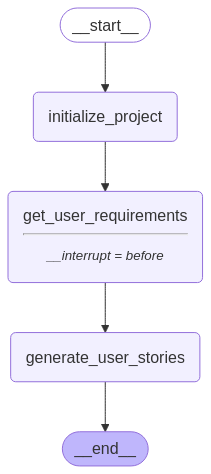

In [6]:
from langgraph.graph import StateGraph,START, END, MessagesState
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


graph_builder = StateGraph(SDLCState)

## Nodes
graph_builder.add_node("initialize_project", initialize_project)
graph_builder.add_node("get_user_requirements", get_user_requirements)
graph_builder.add_node("generate_user_stories", generate_user_stories)
# self.graph_builder.add_node("review_user_stories", self.project_requirement_node.review_user_stories)
# self.graph_builder.add_node("create_design_document", self.design_document_node.create_design_document)

## Edges
graph_builder.add_edge(START,"initialize_project")
graph_builder.add_edge("initialize_project","get_user_requirements")
graph_builder.add_edge("get_user_requirements","generate_user_stories")
graph_builder.add_edge("generate_user_stories",END)

memory = MemorySaver()
graph =graph_builder.compile(
            interrupt_before=[
                'get_user_requirements'
            ],checkpointer= memory
        )

# ✅ Generate the PNG image
img_data = graph.get_graph().draw_mermaid_png( draw_method=MermaidDrawMethod.API)

# ✅ Save the image to a file
graph_path = "workflow_graph.png"
with open(graph_path, "wb") as f:
    f.write(img_data)

# ✅ Display the saved image in Jupyter Notebook
Image(graph_path)

In [ ]:
initial_state = SDLCState(
    project_name="My Project", 
    requirements=["- Requirement 1", "- Requirement 2"]
    )

input1 =  SDLCState(
    project_name="My Project"
    )

thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"project_name": "My Project"}, thread, stream_mode="values"):
     print(f"Event Received: {event}")

graph.update_state(thread, initial_state, as_node="get_user_requirements")

for event in graph.stream(None, thread, stream_mode="values"):
    print(f"Event Received: {event}")

Event Received: {'project_name': 'My Project', 'requirements': ['- Requirement 1', '- Requirement 2'], 'current_node': 'project_initilization'}
Event Received: {'project_name': 'My Project', 'requirements': ['- Requirement 1', '- Requirement 2'], 'current_node': 'project_initilization'}
Event Received: {'project_name': 'My Project', 'requirements': ['- Requirement 1', '- Requirement 2'], 'current_node': 'project_initilization'}
Event Received: {'project_name': 'My Project', 'requirements': ['- Requirement 1', '- Requirement 2'], 'user_stories': UserStoryList(user_stories=[UserStories(id=1, title='User Login', description='As a registered user, I want to log in to the system so that I can access my account and its features.', priority=1, acceptance_criteria='The system should allow users to log in with valid credentials.\nThe system should display an error message for invalid credentials.\nThe system should redirect the user to the dashboard upon successful login.'), UserStories(id=2, t